# 02 - Análisis Exploratorio de Datos: Dengue Regular (Código 210)

**Proyecto:** EDA de Dengue en Colombia  
**Maestría en Inteligencia Artificial** - Desarrollo de Soluciones  

Este notebook realiza el análisis exploratorio de los casos de dengue regular (código SIVIGILA 210) para los años 2010, 2016, 2022 y 2024.

**Contenido:**
1. Distribución temporal de casos por año
2. Análisis por semanas epidemiológicas
3. Distribución geográfica (departamento, municipio)
4. Distribución demográfica (edad, sexo)
5. Tasas de incidencia con datos DANE
6. Análisis por tipo de caso y condición final

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.join('..', 'src'))
from utils import (
    cargar_dengue, cargar_dane, configurar_estilo,
    convertir_edad_anos, clasificar_grupo_etario,
    grafico_barras_por_ano, grafico_semana_epi,
    grafico_top_departamentos, grafico_piramide_edad_sexo,
    grafico_heatmap_dpto_ano, resumen_dataframe,
    COLORES_ANOS, ANOS_DENGUE_REGULAR
)

configurar_estilo()
pd.set_option('display.max_columns', 50)

In [2]:
# Cargar datos
print('Cargando datos de Dengue Regular (210)...')
df = cargar_dengue(tipo='regular')

# Preprocesamiento
cols_fecha = ['FEC_NOT', 'INI_SIN', 'FEC_HOS', 'FEC_DEF', 'FECHA_NTO']
for col in cols_fecha:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

df['edad_anos'] = convertir_edad_anos(df)
df['grupo_etario'] = clasificar_grupo_etario(df['edad_anos'])
df = df.drop_duplicates(subset=['CONSECUTIVE'], keep='first')

resumen_dataframe(df, 'Dengue Regular (210) - Limpio')

Cargando datos de Dengue Regular (210)...
  Cargando Datos_2010_210.xlsx... 147,224 registros, 72 columnas
  Cargando Datos_2016_210.xlsx... 100,117 registros, 72 columnas
  Cargando Datos_2022_210.xlsx... 65,691 registros, 72 columnas
  Cargando Datos_2024_210.xlsx... 309,627 registros, 72 columnas

  Total: 622,659 registros

  Resumen: Dengue Regular (210) - Limpio
  Dimensiones: 622,659 filas x 74 columnas
  Memoria: 1144.1 MB
  Columnas con nulos: 23
    - nacionalidad: 247,341 (39.7%)
    - nombre_nacionalidad: 247,341 (39.7%)
    - GRU_POB: 475,435 (76.4%)
    - nom_grupo: 553,633 (88.9%)
    - estrato: 260,485 (41.8%)
    - sem_ges: 555,344 (89.2%)
    - fuente: 247,341 (39.7%)
    - COD_PAIS_R: 247,341 (39.7%)
    - FEC_HOS: 414,419 (66.6%)
    - FEC_DEF: 622,641 (100.0%)
    - CER_DEF: 622,629 (100.0%)
    - CBMTE: 622,654 (100.0%)
    - FM_FUERZA: 619,457 (99.5%)
    - FM_UNIDAD: 619,460 (99.5%)
    - FM_GRADO: 619,460 (99.5%)
    - Pais_residencia: 247,341 (39.7%)



In [3]:
# Cargar DANE
df_dane = cargar_dane()
print(f'DANE: {len(df_dane):,} municipios cargados')

DANE: 1,131 municipios cargados


## 1. Distribución Temporal de Casos por Año

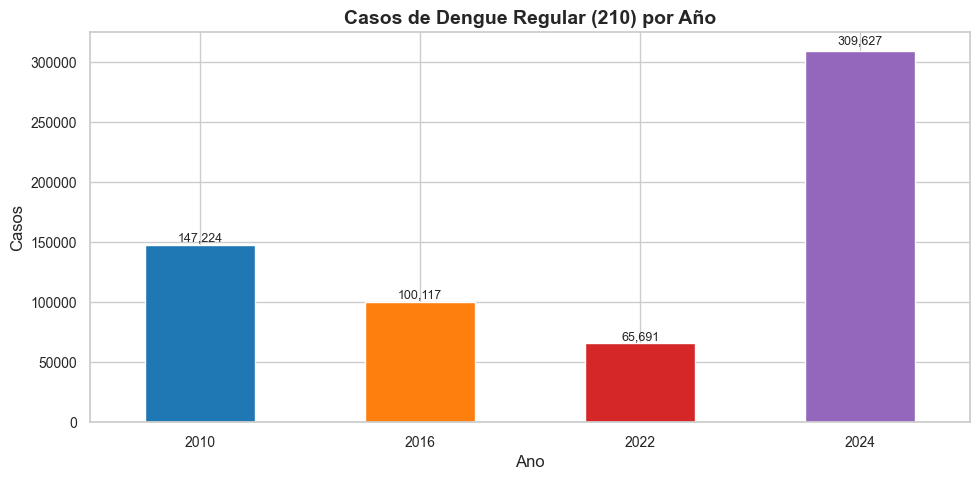


Conteo de casos por año:
ANO
2010    147224
2016    100117
2022     65691
2024    309627


In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
grafico_barras_por_ano(df, titulo='Casos de Dengue Regular (210) por Año', ax=ax)
plt.tight_layout()
plt.show()

print('\nConteo de casos por año:')
print(df['ANO'].value_counts().sort_index().to_string())

## 2. Análisis por Semanas Epidemiológicas

La curva epidémica por semana epidemiológica permite identificar los picos de transmisión en cada año.

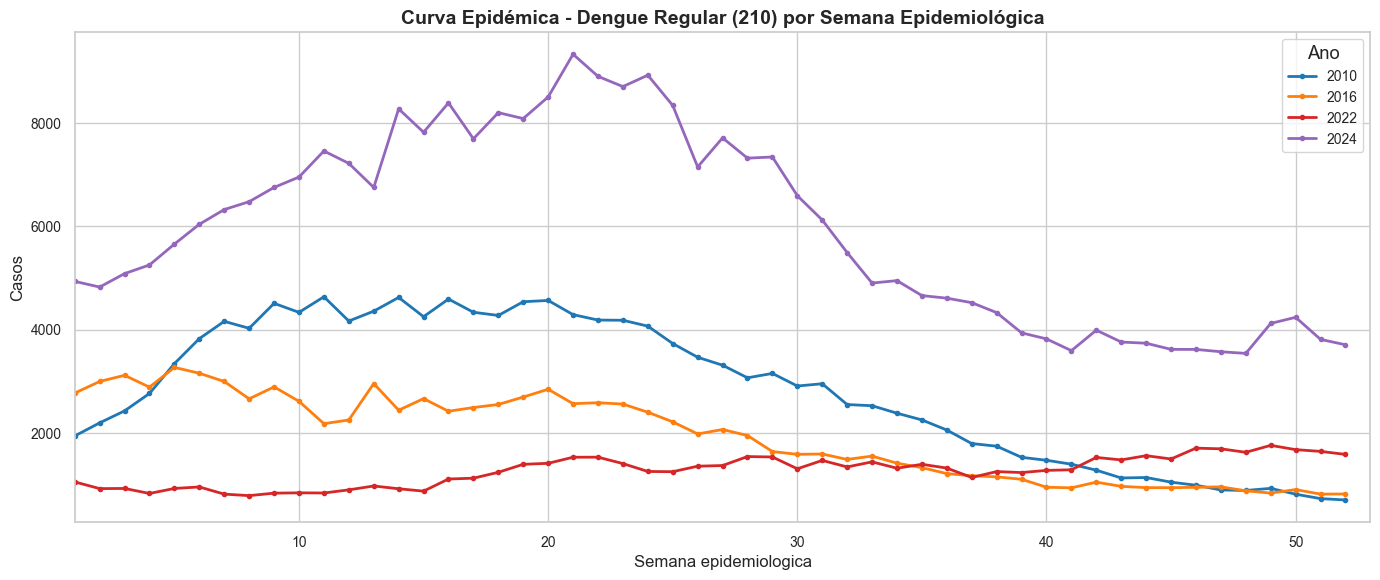

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))
grafico_semana_epi(df, titulo='Curva Epidémica - Dengue Regular (210) por Semana Epidemiológica', ax=ax)
plt.tight_layout()
plt.show()

In [6]:
# Semanas con más casos por año
print('Semana epidemiológica con más casos por año:')
for ano in sorted(df['ANO'].unique()):
    datos_ano = df[df['ANO'] == ano]
    semana_pico = datos_ano['SEMANA'].value_counts().idxmax()
    casos_pico = datos_ano['SEMANA'].value_counts().max()
    print(f'  {ano}: Semana {semana_pico:2d} ({casos_pico:,} casos)')

Semana epidemiológica con más casos por año:
  2010: Semana 11 (4,634 casos)
  2016: Semana  5 (3,266 casos)
  2022: Semana 49 (1,755 casos)
  2024: Semana 21 (9,334 casos)


## 3. Distribución Geográfica

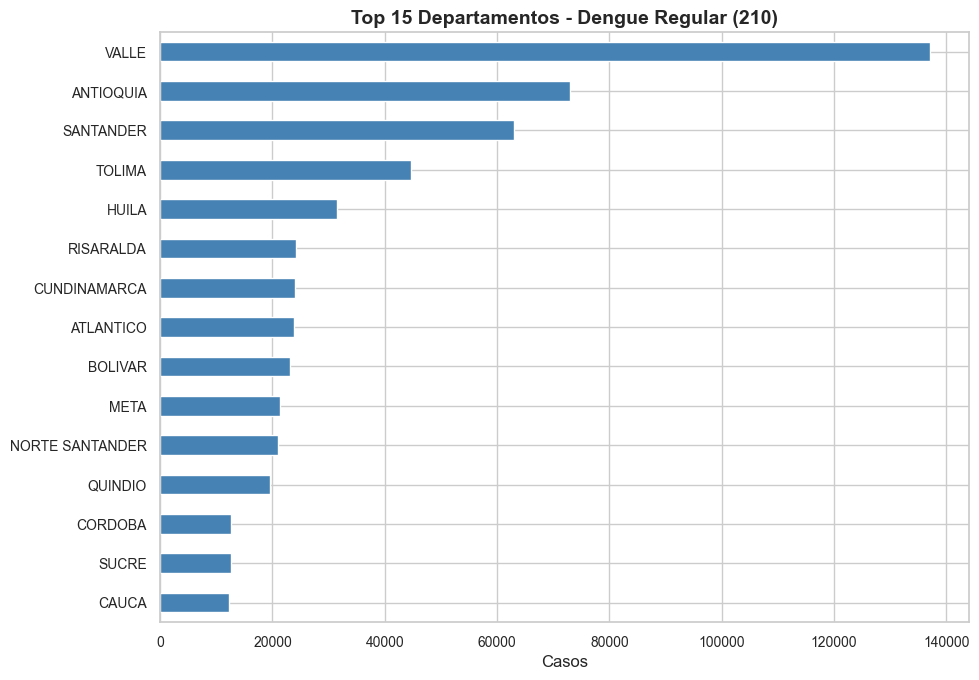

In [7]:
# Top 15 departamentos con más casos
fig, ax = plt.subplots(figsize=(10, 7))
grafico_top_departamentos(df, top_n=15,
                          titulo='Top 15 Departamentos - Dengue Regular (210)', ax=ax)
plt.tight_layout()
plt.show()

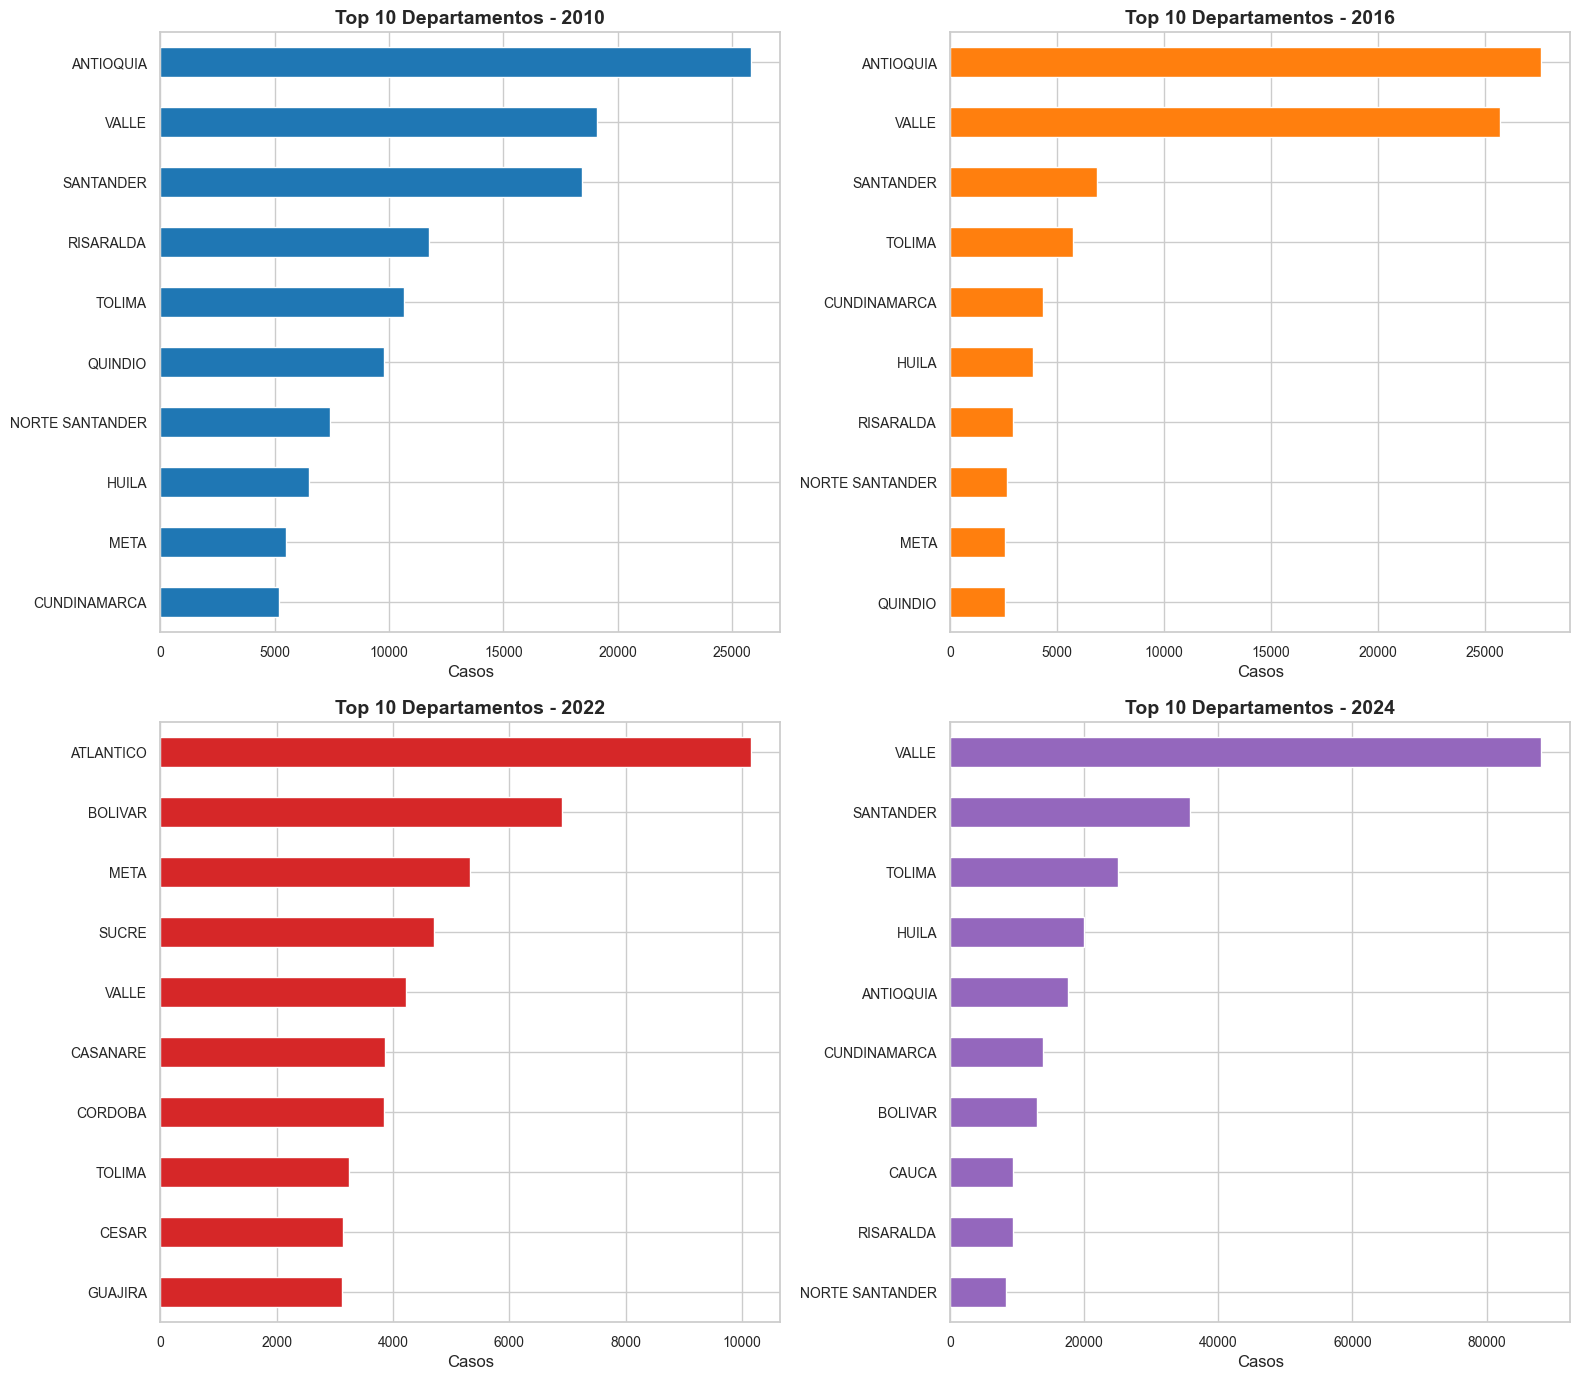

In [8]:
# Top departamentos por cada año
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
anos = sorted(df['ANO'].unique())

for idx, ano in enumerate(anos):
    ax = axes[idx // 2, idx % 2]
    datos_ano = df[df['ANO'] == ano]
    top = datos_ano['Departamento_ocurrencia'].value_counts().head(10)
    top.sort_values().plot(kind='barh', ax=ax, color=COLORES_ANOS.get(ano, 'steelblue'),
                           edgecolor='white')
    ax.set_title(f'Top 10 Departamentos - {ano}', fontweight='bold')
    ax.set_xlabel('Casos')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

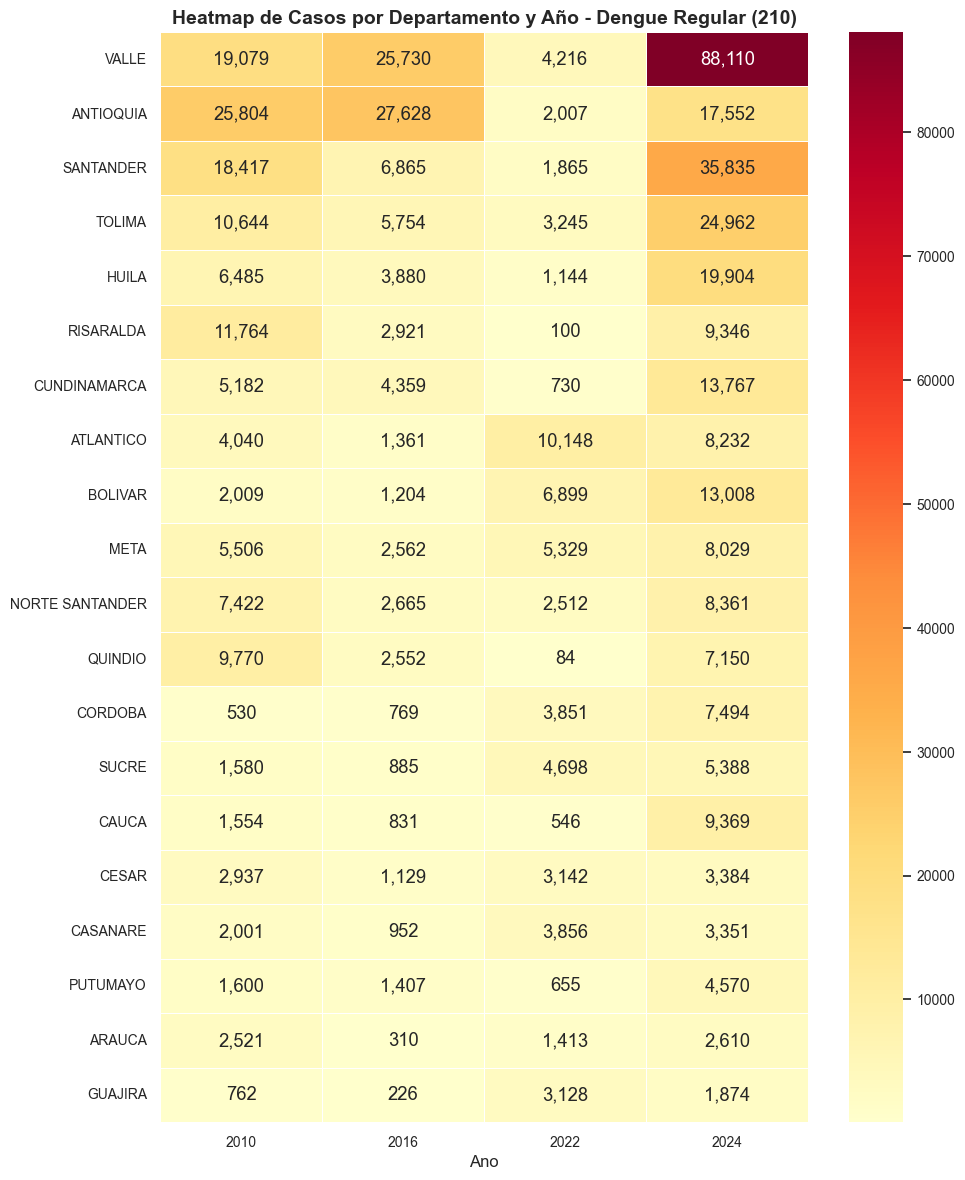

In [9]:
# Heatmap departamento vs año
fig, ax = plt.subplots(figsize=(10, 12))
grafico_heatmap_dpto_ano(df, top_n=20,
                          titulo='Heatmap de Casos por Departamento y Año - Dengue Regular (210)',
                          ax=ax)
plt.tight_layout()
plt.show()

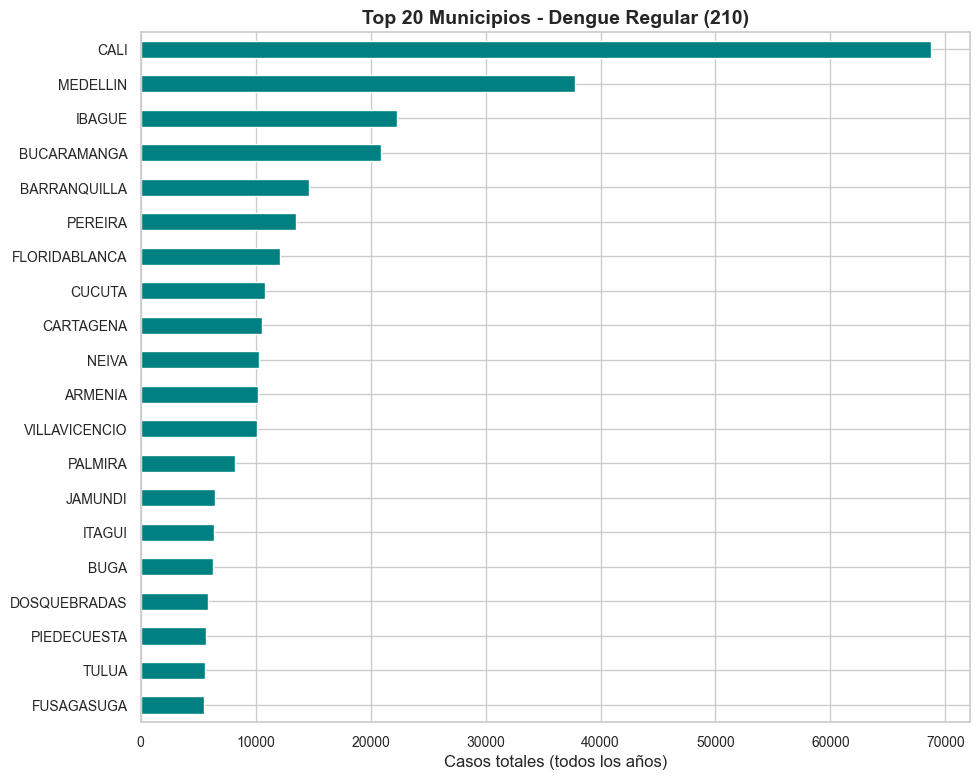

In [10]:
# Top 20 municipios con más casos (total)
top_mpios = df['Municipio_ocurrencia'].value_counts().head(20)

fig, ax = plt.subplots(figsize=(10, 8))
top_mpios.sort_values().plot(kind='barh', ax=ax, color='teal', edgecolor='white')
ax.set_title('Top 20 Municipios - Dengue Regular (210)', fontweight='bold')
ax.set_xlabel('Casos totales (todos los años)')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

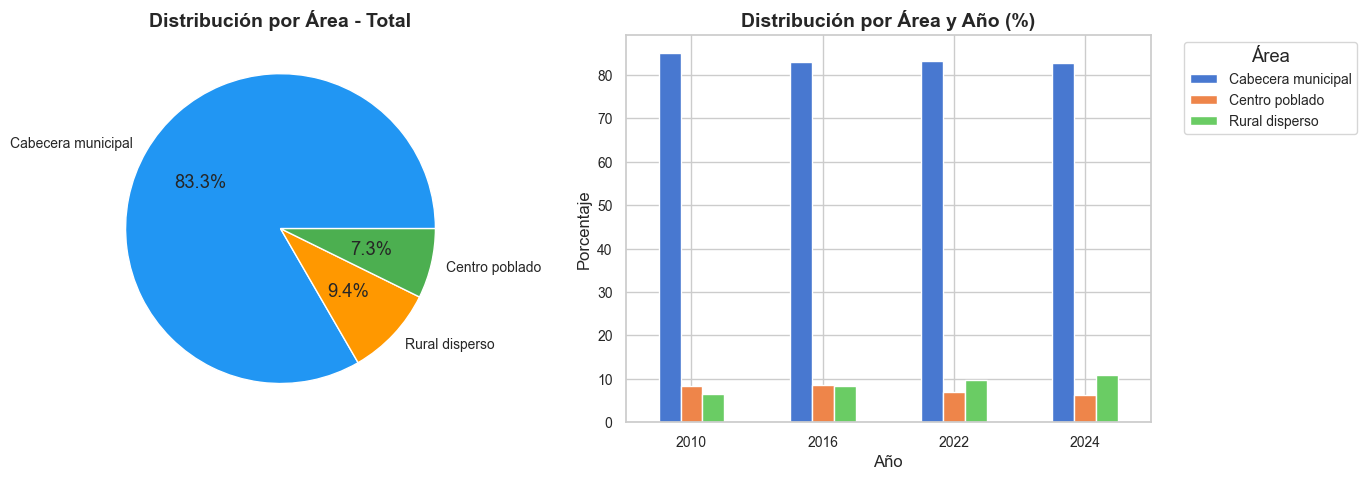

In [11]:
# Distribución urbano vs rural
area_map = {1: 'Cabecera municipal', 2: 'Centro poblado', 3: 'Rural disperso'}
df['area_nombre'] = df['AREA'].map(area_map)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total
df['area_nombre'].value_counts().plot(kind='pie', ax=axes[0], autopct='%1.1f%%',
                                       colors=['#2196F3', '#FF9800', '#4CAF50'])
axes[0].set_title('Distribución por Área - Total', fontweight='bold')
axes[0].set_ylabel('')

# Por año
tabla_area = pd.crosstab(df['ANO'], df['area_nombre'], normalize='index') * 100
tabla_area.plot(kind='bar', ax=axes[1], edgecolor='white')
axes[1].set_title('Distribución por Área y Año (%)', fontweight='bold')
axes[1].set_ylabel('Porcentaje')
axes[1].set_xlabel('Año')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Área', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

## 4. Distribución Demográfica (Edad y Sexo)

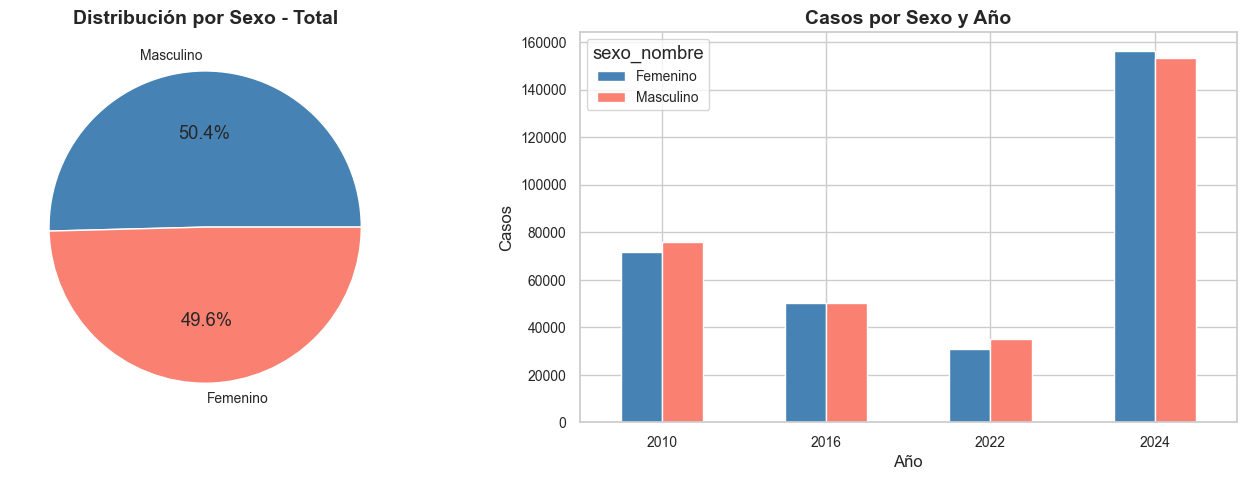

In [12]:
# Distribución por sexo
sexo_map = {'M': 'Masculino', 'F': 'Femenino'}
df['sexo_nombre'] = df['SEXO'].map(sexo_map)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución general
df['sexo_nombre'].value_counts().plot(kind='pie', ax=axes[0], autopct='%1.1f%%',
                                       colors=['steelblue', 'salmon'])
axes[0].set_title('Distribución por Sexo - Total', fontweight='bold')
axes[0].set_ylabel('')

# Por año
tabla_sexo = pd.crosstab(df['ANO'], df['sexo_nombre'])
tabla_sexo.plot(kind='bar', ax=axes[1], color=['steelblue', 'salmon'], edgecolor='white')
axes[1].set_title('Casos por Sexo y Año', fontweight='bold')
axes[1].set_ylabel('Casos')
axes[1].set_xlabel('Año')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

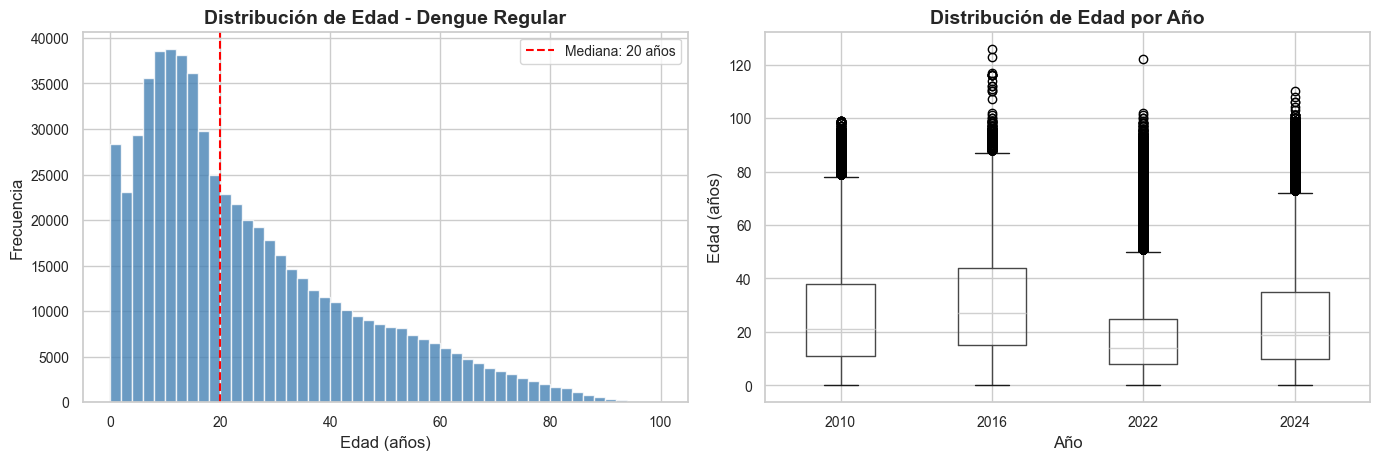

In [13]:
# Distribución de edad
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de edad
df['edad_anos'].dropna().clip(0, 100).hist(bins=50, ax=axes[0], color='steelblue',
                                            edgecolor='white', alpha=0.8)
axes[0].set_title('Distribución de Edad - Dengue Regular', fontweight='bold')
axes[0].set_xlabel('Edad (años)')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(df['edad_anos'].median(), color='red', linestyle='--',
                label=f'Mediana: {df["edad_anos"].median():.0f} años')
axes[0].legend()

# Boxplot por año
df.boxplot(column='edad_anos', by='ANO', ax=axes[1])
axes[1].set_title('Distribución de Edad por Año', fontweight='bold')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Edad (años)')
plt.suptitle('')  # Remover título automático de boxplot

plt.tight_layout()
plt.show()

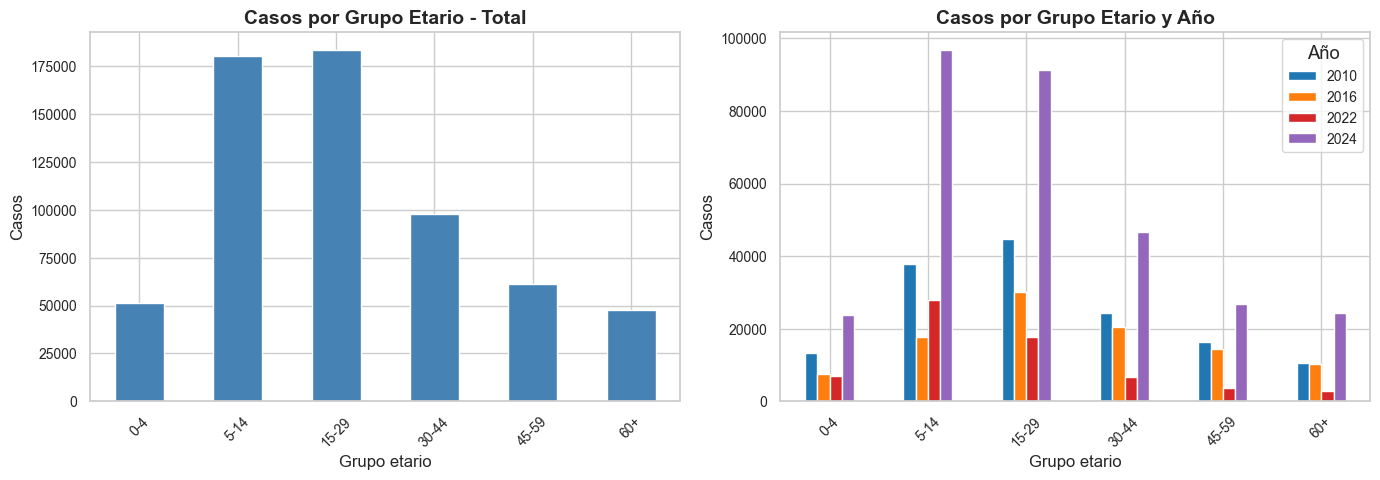

In [14]:
# Distribución por grupo etario
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total
df['grupo_etario'].value_counts().sort_index().plot(kind='bar', ax=axes[0],
                                                     color='steelblue', edgecolor='white')
axes[0].set_title('Casos por Grupo Etario - Total', fontweight='bold')
axes[0].set_ylabel('Casos')
axes[0].set_xlabel('Grupo etario')
axes[0].tick_params(axis='x', rotation=45)

# Por año
tabla_edad = pd.crosstab(df['grupo_etario'], df['ANO'])
tabla_edad.plot(kind='bar', ax=axes[1], edgecolor='white',
                color=[COLORES_ANOS.get(a, '#333') for a in sorted(df['ANO'].unique())])
axes[1].set_title('Casos por Grupo Etario y Año', fontweight='bold')
axes[1].set_ylabel('Casos')
axes[1].set_xlabel('Grupo etario')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Año')

plt.tight_layout()
plt.show()

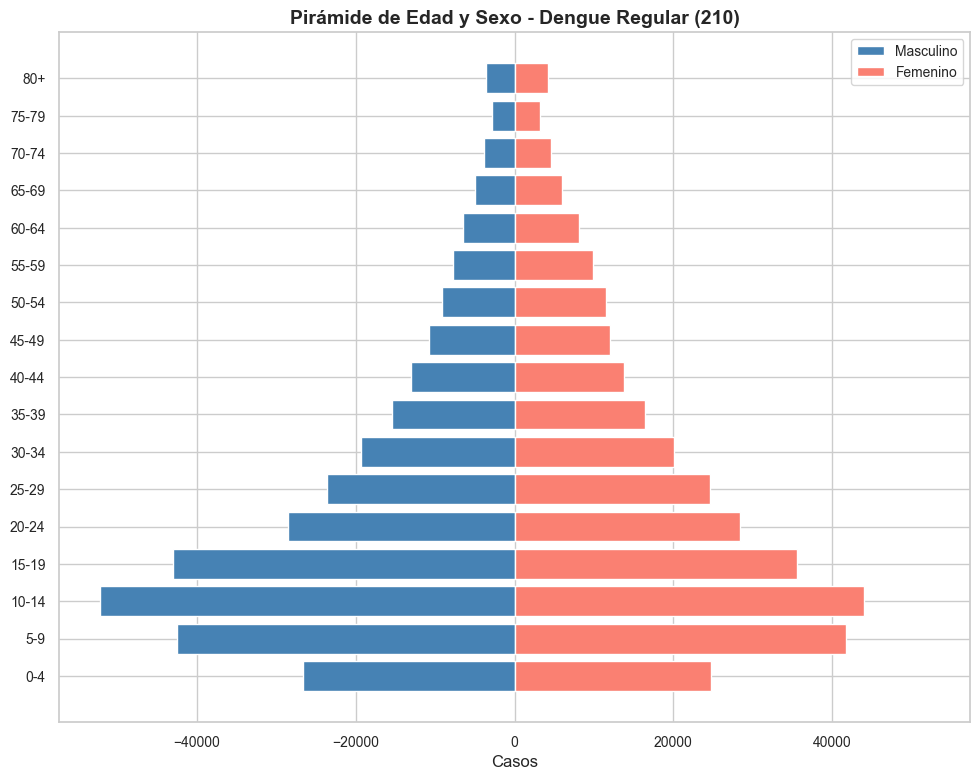

In [15]:
# Pirámide poblacional
fig, ax = plt.subplots(figsize=(10, 8))
grafico_piramide_edad_sexo(df, titulo='Pirámide de Edad y Sexo - Dengue Regular (210)', ax=ax)
plt.tight_layout()
plt.show()

## 5. Tasas de Incidencia

Calculamos tasas de incidencia por 100,000 habitantes usando las proyecciones de población del DANE.

In [16]:
# Calcular población por departamento para los años disponibles en DANE
# Para 2022 y 2024 usamos la proyección de 2020
pob_dpto = df_dane.groupby('departamento').agg({
    'pob_2010': 'sum',
    'pob_2016': 'sum',
    'pob_2020': 'sum',  # Usada como proxy para 2022 y 2024
}).reset_index()

# Estandarizar nombres de departamentos para match
pob_dpto['departamento'] = pob_dpto['departamento'].str.upper().str.strip()

print('Población por departamento (top 10):')
print(pob_dpto.sort_values('pob_2020', ascending=False).head(10).to_string(index=False))

Población por departamento (top 10):
   departamento  pob_2010  pob_2016  pob_2020
   BOGOTÁ, D.C. 7363782.0 7980001.0 8380801.0
      ANTIOQUIA 6065846.0 6534764.0 6845057.0
VALLE DEL CAUCA 4382939.0 4660438.0 4852896.0
   CUNDINAMARCA 2477036.0 2721368.0 2887005.0
      ATLÁNTICO 2314447.0 2489709.0 2601116.0
        BOLÍVAR 1979781.0 2122021.0 2219461.0
      SANTANDER 2010404.0 2071044.0 2110608.0
         NARIÑO 1639569.0 1766008.0 1851658.0
        CÓRDOBA 1582718.0 1736218.0 1838574.0
          CAUCA 1318983.0 1391889.0 1437141.0


In [17]:
# Calcular tasa de incidencia por departamento y año
casos_dpto_ano = df.groupby(['Departamento_ocurrencia', 'ANO']).size().reset_index(name='casos')
casos_dpto_ano['dpto_upper'] = casos_dpto_ano['Departamento_ocurrencia'].str.upper().str.strip()

# Asignar población según año
def obtener_poblacion(row):
    ano = row['ANO']
    dpto = row['dpto_upper']
    match = pob_dpto[pob_dpto['departamento'] == dpto]
    if len(match) == 0:
        return np.nan
    if ano == 2010:
        return match['pob_2010'].values[0]
    elif ano == 2016:
        return match['pob_2016'].values[0]
    else:  # 2022, 2024 -> usar 2020
        return match['pob_2020'].values[0]

casos_dpto_ano['poblacion'] = casos_dpto_ano.apply(obtener_poblacion, axis=1)
casos_dpto_ano['tasa_incidencia'] = (casos_dpto_ano['casos'] / casos_dpto_ano['poblacion']) * 100000

print('Tasas de incidencia calculadas.')
print(f'Departamentos con datos de población: {casos_dpto_ano["poblacion"].notna().sum()}')
print(f'Departamentos sin match: {casos_dpto_ano["poblacion"].isna().sum()}')

Tasas de incidencia calculadas.
Departamentos con datos de población: 80
Departamentos sin match: 54


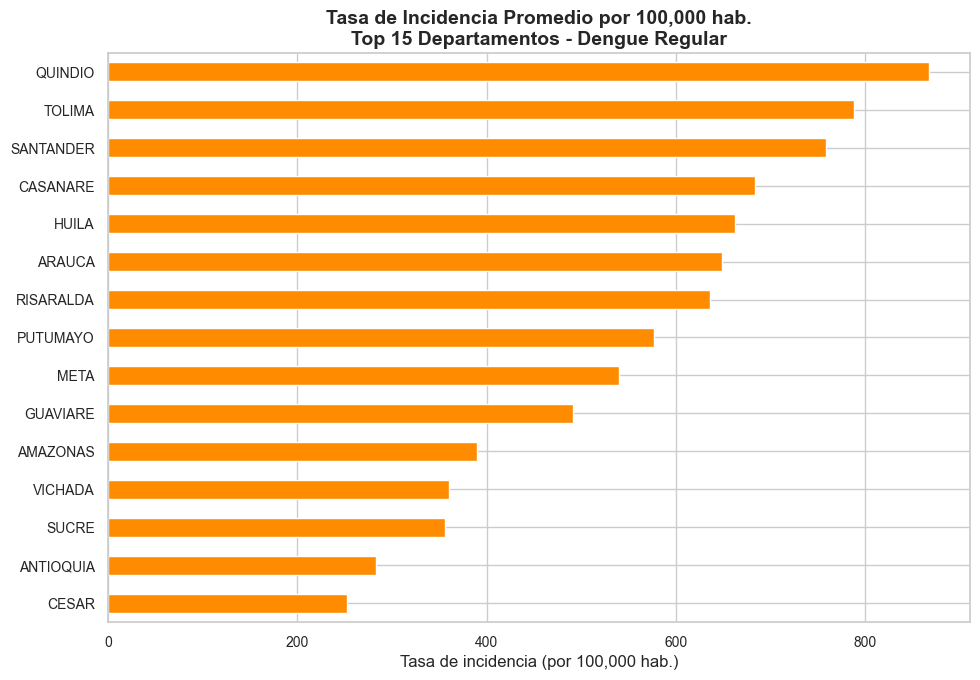

In [18]:
# Top 15 departamentos por tasa de incidencia (promedio de todos los años)
tasa_prom = (casos_dpto_ano.dropna(subset=['tasa_incidencia'])
             .groupby('Departamento_ocurrencia')['tasa_incidencia']
             .mean()
             .sort_values(ascending=False)
             .head(15))

fig, ax = plt.subplots(figsize=(10, 7))
tasa_prom.sort_values().plot(kind='barh', ax=ax, color='darkorange', edgecolor='white')
ax.set_title('Tasa de Incidencia Promedio por 100,000 hab.\nTop 15 Departamentos - Dengue Regular',
             fontweight='bold')
ax.set_xlabel('Tasa de incidencia (por 100,000 hab.)')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

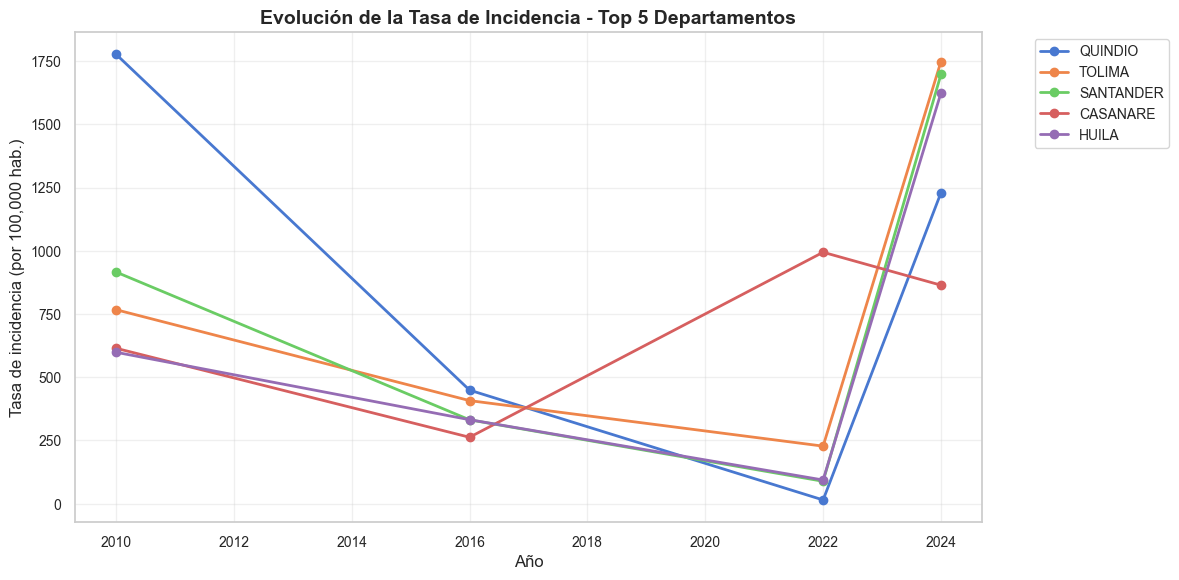

In [19]:
# Evolución de la tasa de incidencia en los departamentos más afectados
top5_dptos = tasa_prom.head(5).index.tolist()

fig, ax = plt.subplots(figsize=(12, 6))
for dpto in top5_dptos:
    datos = casos_dpto_ano[casos_dpto_ano['Departamento_ocurrencia'] == dpto]
    ax.plot(datos['ANO'], datos['tasa_incidencia'], marker='o', linewidth=2, label=dpto)

ax.set_title('Evolución de la Tasa de Incidencia - Top 5 Departamentos', fontweight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('Tasa de incidencia (por 100,000 hab.)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Análisis por Tipo de Caso y Condición Final

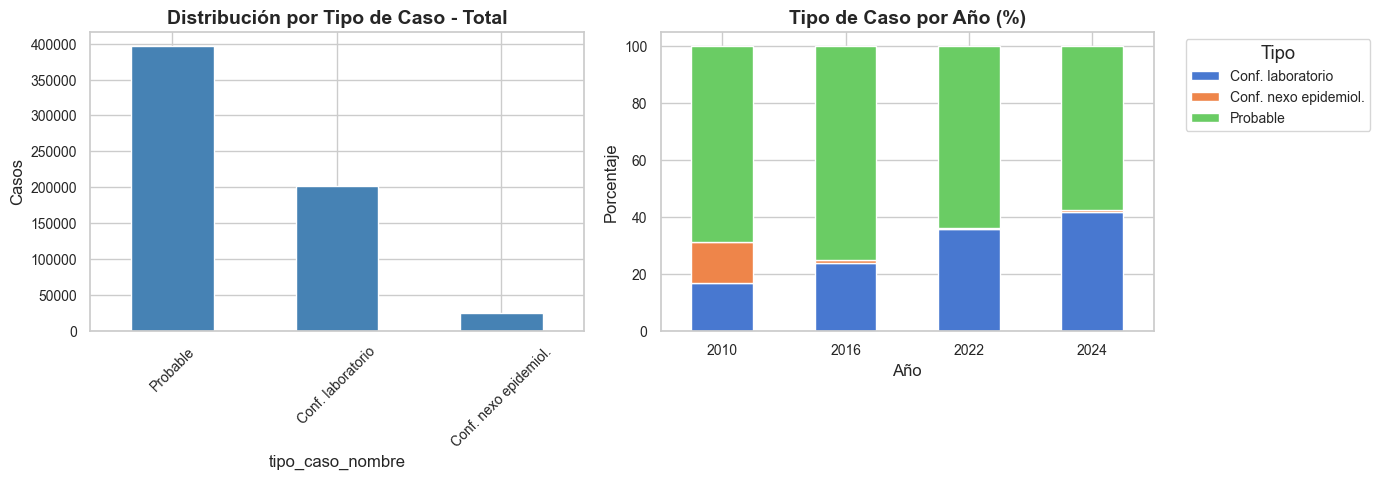

In [20]:
# Tipo de caso (TIP_CAS): 1=Sospechoso, 2=Probable, 3=Confirmado por laboratorio, 4=Confirmado clínico
tip_cas_map = {
    1: 'Sospechoso',
    2: 'Probable',
    3: 'Conf. laboratorio',
    4: 'Conf. clínico',
    5: 'Conf. nexo epidemiol.'
}
df['tipo_caso_nombre'] = df['TIP_CAS'].map(tip_cas_map)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total
df['tipo_caso_nombre'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue',
                                            edgecolor='white')
axes[0].set_title('Distribución por Tipo de Caso - Total', fontweight='bold')
axes[0].set_ylabel('Casos')
axes[0].tick_params(axis='x', rotation=45)

# Por año
tabla_tc = pd.crosstab(df['ANO'], df['tipo_caso_nombre'], normalize='index') * 100
tabla_tc.plot(kind='bar', stacked=True, ax=axes[1], edgecolor='white')
axes[1].set_title('Tipo de Caso por Año (%)', fontweight='bold')
axes[1].set_ylabel('Porcentaje')
axes[1].set_xlabel('Año')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
# Condición final (CON_FIN): 1=Vivo, 2=Muerto
con_fin_map = {1: 'Vivo', 2: 'Muerto', 3: 'No sabe', 9: 'Sin dato'}
df['condicion_final'] = df['CON_FIN'].map(con_fin_map)

print('Condición final de los casos:')
print(df['condicion_final'].value_counts().to_string())

# Tasa de letalidad por año
letalidad = df.groupby('ANO').apply(
    lambda x: (x['CON_FIN'] == 2).sum() / len(x) * 100
).reset_index(name='letalidad_pct')

print(f'\nTasa de letalidad por año (%):')
for _, row in letalidad.iterrows():
    print(f'  {int(row["ANO"])}: {row["letalidad_pct"]:.2f}%')

Condición final de los casos:
condicion_final
Vivo      622629
Muerto        30

Tasa de letalidad por año (%):
  2010: 0.02%
  2016: 0.00%
  2022: 0.00%
  2024: 0.00%


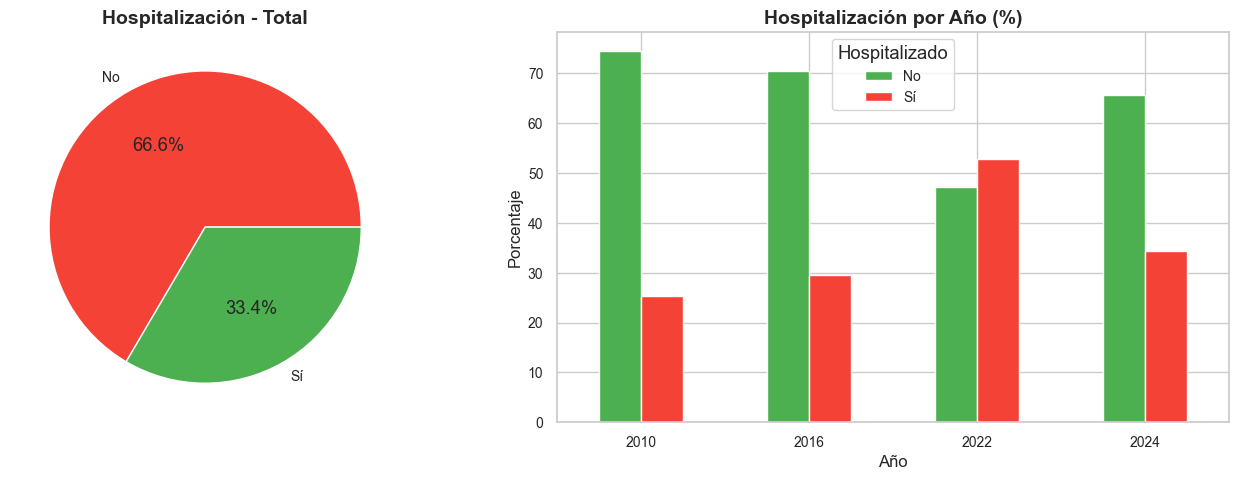

In [22]:
# Hospitalización
pac_hos_map = {1: 'Sí', 2: 'No', 3: 'No sabe'}
df['hospitalizado'] = df['PAC_HOS'].map(pac_hos_map)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['hospitalizado'].value_counts().plot(kind='pie', ax=axes[0], autopct='%1.1f%%',
                                         colors=['#f44336', '#4CAF50', '#9E9E9E'])
axes[0].set_title('Hospitalización - Total', fontweight='bold')
axes[0].set_ylabel('')

tabla_hos = pd.crosstab(df['ANO'], df['hospitalizado'], normalize='index') * 100
tabla_hos.plot(kind='bar', ax=axes[1], edgecolor='white',
               color=['#4CAF50', '#f44336', '#9E9E9E'])
axes[1].set_title('Hospitalización por Año (%)', fontweight='bold')
axes[1].set_ylabel('Porcentaje')
axes[1].set_xlabel('Año')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Hospitalizado')

plt.tight_layout()
plt.show()

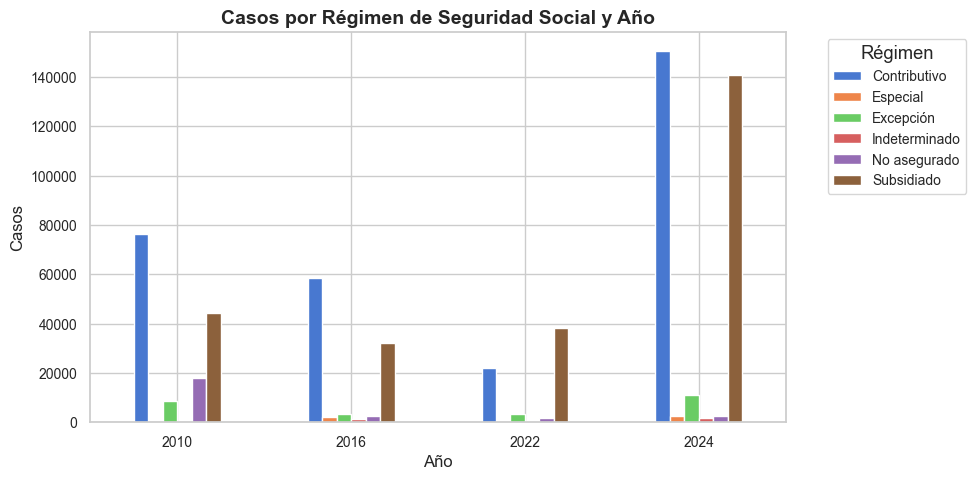

In [23]:
# Tipo de seguridad social
tip_ss_map = {
    'C': 'Contributivo', 'S': 'Subsidiado', 'P': 'Excepción',
    'N': 'No asegurado', 'E': 'Especial', 'I': 'Indeterminado'
}
df['regimen_ss'] = df['TIP_SS'].map(tip_ss_map)

fig, ax = plt.subplots(figsize=(10, 5))
tabla_ss = pd.crosstab(df['ANO'], df['regimen_ss'])
tabla_ss.plot(kind='bar', ax=ax, edgecolor='white')
ax.set_title('Casos por Régimen de Seguridad Social y Año', fontweight='bold')
ax.set_ylabel('Casos')
ax.set_xlabel('Año')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Régimen', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 7. Resumen del EDA - Dengue Regular

In [24]:
print('='*60)
print('  RESUMEN EDA - DENGUE REGULAR (210)')
print('='*60)

print(f'\nTotal de registros analizados: {len(df):,}')
print(f'Años: {sorted(df["ANO"].unique())}')

print(f'\nDistribución temporal:')
for ano in sorted(df['ANO'].unique()):
    n = (df['ANO'] == ano).sum()
    print(f'  {ano}: {n:>8,} casos')

top3_dpto = df['Departamento_ocurrencia'].value_counts().head(3)
print(f'\nTop 3 departamentos (total):')
for dpto, n in top3_dpto.items():
    print(f'  {dpto}: {n:,} casos')

print(f'\nDemografía:')
print(f'  Edad mediana: {df["edad_anos"].median():.0f} años')
print(f'  Rango de edad: {df["edad_anos"].min():.1f} - {df["edad_anos"].max():.0f} años')
sexo_pct = df['sexo_nombre'].value_counts(normalize=True) * 100
for s, p in sexo_pct.items():
    print(f'  {s}: {p:.1f}%')

print(f'\nGrupo etario más afectado: {df["grupo_etario"].value_counts().idxmax()}')

  RESUMEN EDA - DENGUE REGULAR (210)

Total de registros analizados: 622,659
Años: [np.int64(2010), np.int64(2016), np.int64(2022), np.int64(2024)]

Distribución temporal:
  2010:  147,224 casos
  2016:  100,117 casos
  2022:   65,691 casos
  2024:  309,627 casos

Top 3 departamentos (total):
  VALLE: 137,135 casos
  ANTIOQUIA: 72,991 casos
  SANTANDER: 62,982 casos

Demografía:
  Edad mediana: 20 años
  Rango de edad: 0.0 - 126 años
  Masculino: 50.4%
  Femenino: 49.6%

Grupo etario más afectado: 15-29
